In [16]:
from pyspark.sql import functions as F

In [3]:
from pyspark.sql import SparkSession

properties = {
    "user": "root",
    "password": "root",
    "driver": "com.mysql.cj.jdbc.Driver"
}

spark = SparkSession.builder \
    .appName("example") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "1") \
    .config("spark.dynamicAllocation.maxExecutors", "50") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "2") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

In [4]:
df_annee = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="annee", properties=properties).dropna()
df_criminalite = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="criminalite", properties=properties).dropna()
df_commune = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="commune", properties=properties).dropna()
df_demographie = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="demographie", properties=properties).dropna()
df_emploi = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="emploi", properties=properties).dropna()
df_resultats_elections = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="resultats_elections_nuance", properties=properties).dropna()
df_type_election = spark.read.jdbc(url="jdbc:mysql://mysql:3306/mspr1", table="type_election", properties=properties).dropna()

In [55]:
df = df_resultats_elections.join(df_criminalite, on=["id_criminalite"], how="outer")
df = df.join(df_annee, on=["id_annee"], how="outer")
df = df.join(df_commune, on=["id_commune"], how="outer")
df = df.join(df_demographie, on=["id_demographie"], how="outer")
df = df.join(df_emploi, on=["id_emploi"], how="outer")
df = df.join(df_type_election, on=["id_type_election"], how="outer").cache()
# .join(df_elections, on=["codecommune", "annee"], how="outer").join(df_communes, on=["codecommune"], how="outer").cache()

In [58]:
df_annee.unpersist()
df_criminalite.unpersist()
df_commune.unpersist()
df_demographie.unpersist()
df_resultats_elections.unpersist()
df_type_election.unpersist()

DataFrame[id_type_election: int, type_election: string, tour: string]

In [59]:
df_toutes_infos = df.dropna().cache()

In [60]:
df_toutes_infos.count()

309431

In [61]:
# df_filtered_year = df_toutes_infos.filter(F.col("annee") > 1990).cache()

In [63]:
df_filtered_year.sample(0.01).count()

3091

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
# Assuming you have a Pandas DataFrame to convert the Spark DataFrame into Pandas for plotting
df_pandas = df_filtered_year.sample(0.0045).toPandas()

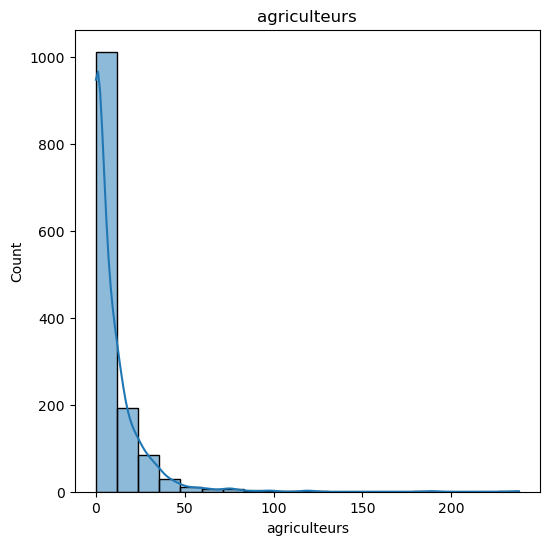

In [66]:
plt.figure(figsize=(6, 6))

plt.subplot(1,1,1)
sns.histplot(df_pandas['agriculteurs'], kde=True, bins = 20)
plt.title("agriculteurs")

plt.show()

In [ ]:
X = df_pandas[["population", "", "", "", "", "", "", "", ""]]

In [5]:
# spark.stop()

In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["pourcentage_voix_inscrits", "autre_pourcentage_voix_inscrits", "egauche_pourcentage_voix_inscrits", "gauche_pourcentage_voix_inscrits", "cgauche_pourcentage_voix_inscrits", "centre_pourcentage_voix_inscrits", "cdroit_pourcentage_voix_inscrits", "droite_pourcentage_voix_inscrits", "edroite_pourcentage_voix_inscrits"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

df = assembler.transform(df)

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Create a Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='label_column')  # Replace 'label_column' with your target variable

# Fit the model on the training data
lr_model = lr.fit(train_data)

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors

# Create a Spark session
spark = SparkSession.builder.appName("Scaling").getOrCreate()

# Sample Data
data = [(0, Vectors.dense([10.0, 100.0, 1000.0])),
        (1, Vectors.dense([20.0, 200.0, 2000.0])),
        (2, Vectors.dense([30.0, 300.0, 3000.0]))]
df = spark.createDataFrame(data, ["id", "features"])


scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit the scaler and transform the data
scaler_model = scaler.fit(df)
scaled_df = scaler_model.transform(df)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator